In [1]:
import os
import shutil
from pathlib import Path

In [49]:
categories = ['Skin', 'Tongues', 'Lips', 'Eyes']
labels = ['Yes', 'No']

for category in categories:
    for label in labels:
        dest = os.path.join('data', category.lower(), label.lower())
        Path(dest).mkdir(parents=True, exist_ok=True)
        source = os.path.join('Dataset', label, category)
        for filename in os.listdir(source):
            shutil.copyfile(os.path.join(source, filename), os.path.join(dest, filename))

In [50]:
import torch
import torchvision
from torchvision import transforms, models, datasets
from torch import nn
from torch import optim
import time
import copy
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [51]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder('data/eyes', transform=transform)
trainsize = ceil(len(dataset) * 0.8)
testsize = len(dataset) - trainsize
trainset, testset = torch.utils.data.random_split(dataset, [trainsize, testsize])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=0)
dataset_sizes = {'train': trainsize, 'val': testsize}
class_names = dataset.classes
dataloaders = { 'train': trainloader, 'val': testloader }

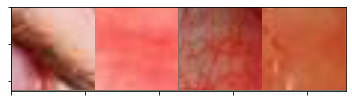

In [52]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [54]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [55]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4707 Acc: 0.8307
val Loss: 0.2860 Acc: 0.8936

Epoch 1/24
----------
train Loss: 0.3780 Acc: 0.8624
val Loss: 0.3162 Acc: 0.8723

Epoch 2/24
----------
train Loss: 0.3794 Acc: 0.8783
val Loss: 0.5773 Acc: 0.6809

Epoch 3/24
----------
train Loss: 0.3535 Acc: 0.8677
val Loss: 0.3885 Acc: 0.8723

Epoch 4/24
----------
train Loss: 0.4657 Acc: 0.8307
val Loss: 0.2629 Acc: 0.9149

Epoch 5/24
----------
train Loss: 0.3347 Acc: 0.8677
val Loss: 0.2498 Acc: 0.9149

Epoch 6/24
----------
train Loss: 0.2933 Acc: 0.8624
val Loss: 0.2284 Acc: 0.9574

Epoch 7/24
----------
train Loss: 0.2261 Acc: 0.8942
val Loss: 0.2087 Acc: 0.9574

Epoch 8/24
----------
train Loss: 0.2244 Acc: 0.9101
val Loss: 0.2123 Acc: 0.9362

Epoch 9/24
----------
train Loss: 0.2770 Acc: 0.8995
val Loss: 0.2212 Acc: 0.9362

Epoch 10/24
----------
train Loss: 0.2412 Acc: 0.9048
val Loss: 0.2169 Acc: 0.9362

Epoch 11/24
----------
train Loss: 0.2600 Acc: 0.8889
val Loss: 0.2270 Acc: 0.9574

Ep

In [43]:
pos = 0
neg = 0
for i in testset.indices:
    if dataset[i][1] == 0:
        pos += 1
    else:
        neg += 1
print(pos / (pos + neg))

79
59
